# Probability speedrun

## Classification tasks
So far, we've been focussing on *regression* tasks in machine learning, in which the goal is to predict the value of a  continuous target. In this lesson, we'll shift our focus to *classification*, in which the goal is to predict the value of a discrete target variable.

Thus, we will be working within the following set-up: We are given a labelled (training) dataset with the following specifications:
- The dataset consists of $m$ instances.
- There are $n$ features $X_1,\dotsc,X_n$ (continuous or categorical) associated with each instance, each represented by a feature vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a target variable $Y$ that is categorical, and can take values in a finite set of *classes* $C = \mathcal{C}$. This is represented by a target vector $\mathbf{y} \in C^m$. 
The goal of the classification model (referred to as a *classifier*) is to learn a ground truth function
\begin{equation*}
    f: \mathbb{R}^n \to C
\end{equation*}
which outputs a class label given a particular combination of values of the features. 

When $k=2$ (i.e. $C$ consists of only two classes), we have a *binary classification* problem. Binary targets can always be interpreted as yes/no answers to a question, such as "Is this email spam?" or "Does this patient have a particular disease?", or "Will this customer buy this product?".

When $k>2$, we have a *multi-class classification* problem.  Multi-class targets can similarly be interpreted as answers to questions such as "What type of animal is in this image?" or "What is the genre of this song?", or (in the case of large language models) "What is the next word in this sentence?".

### A visual perspective
Classification can be understood quite intuitively from a visual perspective. Namely, let's associate a color to each of the possible classes $c_1,\dotsc,c_k$. Then, we can visualize the dataset as a collection of $m$ points in the feature space $\mathbb{R}^n$. The goal of a classifier is to partition the feature space into $k$ regions $R_1,\dotsc,R_k$, each corresponding to a color $c_i$. To predict the class of a given a data point $\vec{x} \in \mathbb{R}^n$, the classifier simply checks which of these regions $R_i$ the point lies in, and it predicts the class to be the corresponding color $c_i$. 

The boundaries that separate the various regions in $\mathbb{R}^n$ are called **decision boundaries**, so named because the decision to assign a particular class changes when one crosses the boundary from one region to another. Classifiers are sometimes referred to as *linear classifiers*, *quadratic classifiers*, and so on, depending on the nature/curvature of these decision boundaries. 

The simplest to understand are the linear classifiers, which use decision boundaries that are straight lines/planes, etc. We will cover two well-known linear classifiers:
1. **Perceptrons**: The simplest possible linear classifier for binary classification that uses a step function to make predictions. These are the building blocks of neural networks.
2. **Logistic regression**: A linear classifier that uses a logistic function to make predictions. These are one of the most widely used classifiers in practice, and the multi-class version of logistic regression is used as the last step in many neural network architectures.

Below, we visualize a simple binary classification problem with two features, and the decision boundary of a logistic regression classifier. 

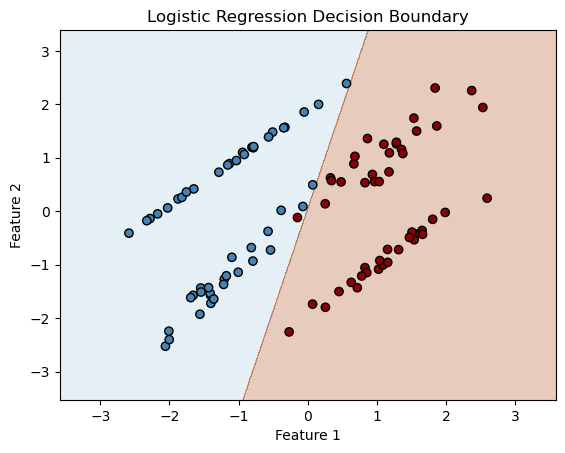

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Generate synthetic data
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
colors = ['darkred' if label == 1 else 'steelblue' for label in y]

# Fit logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Create a mesh to plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict probabilities for each point in the mesh
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

We will discuss perceptrons and logistic regression in detail a couple of classes later. For this class, the goal will instead be to develop some basics of probability theory that will be useful for understanding these classifiers. To that end, we turn our attention to the concept of probabilistic classifiers. 

### Probabilistic Classifiers

A probabilistic classifier, also known as a **soft classifier**, is a type of classifier that outputs not just a class label for each input data point, but also a probability distribution over all possible class labels. This means that for each input, the classifier provides the probabilities that the input belongs to each of the possible classes; these are called **predicted probabilities**.

Given the output of a soft classifier, one can convert it into a **hard classifier** (which is one which predicts exactly one class label per instance) by simply taking the class with the highest probability. For example, if a soft classifier outputs the probabilities $P(c_1 \mid  \mathbf{x}) = 0.7$, $P(c_2 \mid  \mathbf{x}) = 0.2$, and $P(c_3 \mid  \mathbf{x}) = 0.1$, then the hard classifier would predict class $c_1$ for the input $\mathbf{x}$. In some cases, one may want to use a different **decision threshold** for the probabilities, and classify an input as belonging to a certain class only if the probability exceeds a specific threshold. For example, one may want to classify an input as class $c_1$ only if $P(c_1 \mid  \mathbf{x}) > 0.8$. (This notation will be explained below.)

Key characteristics of probabilistic classifiers include:

1. **Probability Distribution**: They provide a probability distribution over all classes, which sums to 1.
2. **Confidence Scores**: The probabilities can be interpreted as confidence scores, indicating how confident the classifier is in its predictions.
3. **Threshold Flexibility**: They allow for flexible decision thresholds; that is, you can classify an input as belonging to a certain class only if the probability exceeds a specific threshold.
4. **Uncertainty Quantification**: They enable the quantification of uncertainty in predictions, which is useful in many applications where understanding the uncertainty is important.

Our focus in the next class will be to discuss some classifiers that are based on *Baye's Theorem*. To that end, we devote the rest of this notebook to reviewing some basic concepts from probability theory. 

## Probability theory speedrun
In this section, we will cover some key concepts in probability theory that are relevant to classification tasks.

### 1. Probability spaces 
A probability space consists of a set of possible outcomes $\Omega$ (called the *sample space*), together with a probability measure $P$ that assigns a probability to each *event* (i.e. subset of $\Omega$). The probability measure must satisfy the following properties:
- $P(A) \geq 0$ for all events $A \subseteq \Omega$.
- $P(\Omega) = 1$.
- If $A_1, A_2, \dotsc$ are disjoint events (i.e. distinct subsets), then $P\left(\bigcup_i A_i\right) = \sum_i P(A_i)$.
In the context of ML, probability spaces arise naturally when we consider the possible values of a variable in a dataset. In these cases, the sample space is the set of all possible values that the variable can take (which we previously called the *support* of the variable), and the probability measure assigns a probability to each possible subset of values. 

Moreover, we saw that this measure arises naturally by constructing a suitable proabability function, which takes on two guises depending on whether the variable is continuous or discrete:
- In the discrete case, we have a probability mass function (PMF) $p_X: \Omega \to [0,1]$, which gives the probability that the random variable $X$ takes on the value $x$ (i,e, $p_X(x) = P(X=x)$). For a general event $S \subset \Omega$, the probability is given by $$P(S) = P(X \in S) = \sum_{x \in S} p_X(x).$$
- In the continuous case, we have a probability density function (PDF) $f_X: \Omega \to [0,\infty)$, which gives the density of the random variable $X$ at the value $x$. (Recall that the PDF can be understood as smoothed version of a histogram.) For a general event $S \subset \Omega$, the probability is given by $$P(S) = P(X \in S) = \int_S f_X(x) dx.$$

### 2. Joint probabilities
If we have two variables $X_1$ and $X_2$, with sample spaces $\Omega_1$ and $\Omega_2$, then we may wish to consider the probability of both variables taking on particular values simultaneously. That is:
- We first create a new sample space $\Omega_1 \times \Omega_2$, which consists of all possible pairs $(x_1, x_2)$, where $x_1 \in \Omega_1$ and $x_2 \in \Omega_2$.
- Then, for any event $S \subset \Omega_1 \times \Omega_2$, we define the joint probability $P(S)$ as the probability that both $X_1$ and $X_2$ take on values in $S$:
$$P(S) = P((X_1, X_2) \in S).$$
Joint probabilities for more than two distributions are defined similarly.

A probability distribution for a single variable (in a dataset with multiple variables) is sometimes called the **marginal distribution** of that variable. This can be visualized as a histogram or a curve, with the $x$-axis representing the sample space $\Omega$, and the $y$-values representing the probabilities or densities. In either case, the total area under the curve (or of the histogram bins) must equal 1.

Computing the marginal distribution of a variable from the joint distribution is done by summing or integrating over the other variable. For example, if we know the joint distribution of two variables $X_1$ and $X_2$ (with supports $\Omega_1$ and $\Omega_2$, respectively), then the marginal distribution of $X_1$ is given by
$$P(X_1=x_1) = \sum_{x_2 \in \Omega_2} P(X_1=x_1, X_2 = x_2).$$
Similarly, if they are continuous, we compute the marginal distribution of $X_1$ by integrating over $X_2$:
$$P(X_1=x_1) = \int_{\Omega_2} P(X_1=x_1, X_2 = x_2) dx_2.$$

For two variables, the joint distribution can be visualized as a 3D surface (or histogram with 3D pillars), with the $x$- and $y$-axes representing the sample spaces $\Omega_1$ and $\Omega_2$, and the $z$-axis representing the joint probabilities. This time, the  total *volume* under the surface (or of the histogram pillars) must equal 1. Let's illustrate this by visualizing the joint distribution of two discrete variables from the `car_evaluation` dataset.

In [3]:
# import libraries
import numpy as np
import pandas as pd

cars = pd.read_csv('../data/classification/car_evaluation/train.csv')
vars = pd.read_csv('../data/classification/car_evaluation/data_description.csv')
vars = vars[['new_col_name', 'name', 'type', 'role']]
vars

,new_col_name,name,type,role
0,X1,buying,Categorical,Feature
1,X2,maint,Categorical,Feature
2,X3,doors,Categorical,Feature
3,X4,persons,Categorical,Feature
4,X5,lug_boot,Categorical,Feature
5,X6,safety,Categorical,Feature
6,Y,class,Categorical,Target


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider
import matplotlib.gridspec as gridspec

np.random.seed(0)
# Use the categorical columns directly (they should contain the class names)
X1 = cars['X1'].values  # Expected values: 'low', 'med', 'high', 'vhigh'
Y = cars['Y'].values    # Expected values: 'unacc', 'acc', 'good', 'vgood'

# Manually created lists for desired ordering
x1_order = ['low', 'med', 'high', 'vhigh']
y_order = ['unacc', 'acc', 'good', 'vgood']

def plot_3d_hist(azim=45, elev=30):
    # Use the manually defined order for X1 and Y
    x_unique = np.array(x1_order)
    y_unique = np.array(y_order)
    
    # Compute the joint frequency count
    counts = np.zeros((len(y_unique), len(x_unique)))
    for i, y_val in enumerate(y_unique):
        for j, x_val in enumerate(x_unique):
            counts[i, j] = np.sum((X1 == x_val) & (Y == y_val))
            
    total = counts.sum()            
    # Normalize counts to probabilities 
    prob = counts / total
            
    # Compute marginal distributions
    marg_x1 = counts.sum(axis=0) / total
    marg_y = counts.sum(axis=1) / total
            
    # Prepare data for the 3D joint plot
    xpos, ypos = np.meshgrid(np.arange(len(x_unique)), np.arange(len(y_unique)))
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like(xpos)
    dx = 0.8
    dy = 0.8
    dz = prob.flatten()
            
    # Create a figure with subplots using GridSpec:
    fig = plt.figure(figsize=(8, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[3, 1],
                           hspace=0.3, wspace=0.3)
            
    # X1 marginal distribution (top left)
    ax_x = fig.add_subplot(gs[0, 0])
    ax_x.bar(x_unique, marg_x1, color=(0.7, 0.8, 1, 0.7), width=0.8)
    ax_x.set_xticks(np.arange(len(x_unique)))
    ax_x.set_xticklabels(x_unique)
    ax_x.set_xlabel('X1 Categories')
    ax_x.set_ylabel('Probability')
    ax_x.set_title('Marginal Distribution of X1')
            
    # Y marginal distribution (bottom right)
    ax_y = fig.add_subplot(gs[1, 1])
    ax_y.barh(np.arange(len(y_unique)), marg_y, color=(0.7, 0.8, 1, 0.7), height=0.8)
    ax_y.set_yticks(np.arange(len(y_unique)))
    ax_y.set_yticklabels(y_unique)
    ax_y.set_ylabel('Y Categories')
    ax_y.set_xlabel('Probability')
    ax_y.set_title('Marginal Distribution of Y')
            
    # Joint 3D histogram (bottom left)
    ax_joint = fig.add_subplot(gs[1, 0], projection='3d')
    ax_joint.bar3d(xpos, ypos, zpos, dx, dy, dz, color=(0.7, 0.8, 1, 0.7), shade=True)
    ax_joint.set_xticks(np.arange(len(x_unique)) + dx/2)
    ax_joint.set_xticklabels(x_unique)
    ax_joint.set_yticks(np.arange(len(y_unique)) + dy/2)
    ax_joint.set_yticklabels(y_unique)
    ax_joint.set_zlabel('Probability')
    ax_joint.set_xlabel('X1')
    ax_joint.set_ylabel('Y')
    ax_joint.azim = azim
    ax_joint.elev = elev
    ax_joint.set_title('Joint Distribution of X1 and Y')
            
    plt.suptitle('3D Histogram with Marginal Distributions (Bad to Good)', fontsize=16)
    plt.show()

interact(
    plot_3d_hist,
    azim=IntSlider(min=0, max=360, step=5, value=45, description='Azimuth'),
    elev=IntSlider(min=0, max=90, step=5, value=30, description='Elevation')
)

interactive(children=(IntSlider(value=45, description='Azimuth', max=360, step=5), IntSlider(value=30, descrip…

<function __main__.plot_3d_hist(azim=45, elev=30)>

### 3. Conditional probabilities
Conditional probabilities are a way to quantify the likelihood of an event given that another event has occurred. The conditional probability of event $A$ given event $B$ is denoted by $P(A\mid B)$, and is defined as
$$P(A\mid B) = \frac{P(A \cap B)}{P(B)},$$
provided that $P(B) > 0$. The logic for this formula is as follows:
- The probability of $A$ and $B$ both occurring (i.e. the joint probability) is given by $P(A \cap B)$. The probability of $A$ *not* occuring simultaneously as $B$ occurs is given by $P(A^c \cap B)$.
- The sum of the above two quantities is the probability that $B$ occurs, i.e. $P(B)$. Therefore, the probability that $A$ occurs given that $B$ occurs is the ratio of the probability that both occur to the probability that $B$ occurs.
- Note that, when we add up the joint probabilities of $B$ with all possible values of $A$, we get $P(B)$. Thus, dividing by $P(B)$ has the effect of normalizing the joint probabilities (i.e. converting them into conditional probabilities) that add up to $1$. In effect, we've restricted our sample space to the event $B$, and are now considering the probabilities of $A$ within this restricted space!

In the context of ML, the event $B$ typically comes from one variable, and the event $A$ comes from another variable. For example, if we have a discrete feature $X$ and target $Y$, then $P(Y\mid X)$ is the probability of the target $Y$ given the feature $X$. More precisely, given values $x$ and $y$ of $X$ and $Y$, respectively, $P(Y=y\mid X=x)$ is the probability that the target is $y$ given that the feature is $x$. By the above formula, we have
\begin{equation*}
    P(Y=y\mid X=x) = \frac{P(Y=y, X=x)}{P(X=x)}.
\end{equation*}
This formula is the basis for the Naïve Bayes classifier, which we will discuss a couple of sections down.

First, let's illustrate the concept of conditional probabilities by visualizing the conditional distribution of the target variable given the feature `X3` (i.e. `doors`) from the `car_evaluation` dataset.

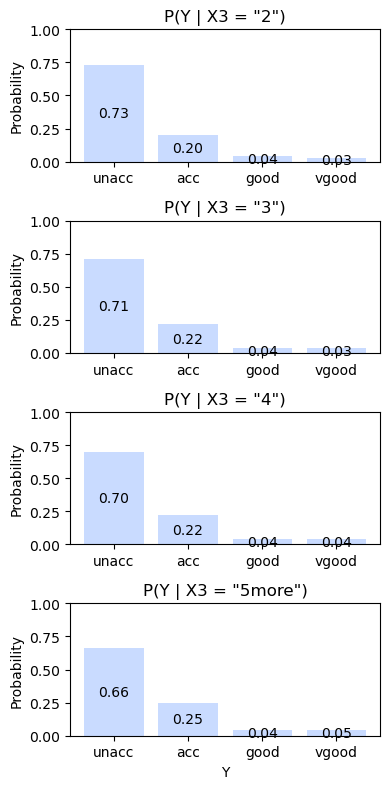

In [ ]:
# Get the possible unique values (and ordering if desired) for X3 and Y.
x3_order = sorted(cars['X3'].unique())  # e.g., ['2', '3', '4', '5more'] if these are the door categories
y_order = ['unacc', 'acc', 'good', 'vgood']

n_x3 = len(x3_order)
fig, axs = plt.subplots(n_x3, 1, figsize=(4, 2 * n_x3))
if n_x3 == 1:
    axs = [axs]

for i, x3_val in enumerate(x3_order):
    # Filter the dataset for the current X3 value
    subset = cars[cars['X3'] == x3_val]
    
    # Compute counts and then probabilities for each Y category
    counts = np.array([np.sum(subset['Y'] == y_val) for y_val in y_order])
    total = counts.sum()
    prob = counts / total if total > 0 else np.zeros_like(counts)
    
    ax = axs[i]
    bars = ax.bar(y_order, prob, color=(0.7, 0.8, 1, 0.7))
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title(f'P(Y \mid  X3 = "{x3_val}")')
    
    # Annotate each bar with its probability value inside the bar
    for bar, p in zip(bars, prob):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # horizontal center of the bar
            height / 2,                         # vertical position: mid-bar
            f'{p:.2f}',                         # formatted probability
            ha='center', va='center', color='black'
        )

plt.xlabel('Y')
plt.tight_layout()
plt.show()

### 4. Independence
The above visualization shows us that the probability distribution of `Y` does not appear to change much at all depending on the particular value of `X3`, i.e. it appears that the probability of `Y` is *independent* of `X3`. This leads us naturally to the fundamental concept of independence in probability theory: two events $A$ and $B$ are said to be independent if the occurrence of one does not affect the probability of the other. In other words, $A$ and $B$ are **independent** if $$P(A\mid B) = P(A),$$ or equivalently, if $$P(A \cap B) = P(A)P(B).$$

In practice, we are interested often in cases where the events arise from values being taken by distinct variables. For instance, $A$ could represent the event that $X=x$ and $B$ could represent the event that $Y=y$. In this case, independence of these two events is saying that 
$$P(Y=y, X=x) = P(Y=y)P(X=x).$$
When this holds for all possible values of $X$ and $Y$, we say that the variables $X$ and $Y$ are independent. In other words, they are independent if the joint probability distribution of the two variables is simply the product of the marginal probability distributions.

For example, the previous visualization suggests that the target `Y` and the feature `X3` are independent (almost). 

The notion of independence can be extended naturally to a collection of variables $X_1,\dotsc,X_n$, collectively denoted $\vec{X}$. We say that these are independent if the joint probability of all the variables is the product of the marginal probabilities. That is, for all possible values $x_1,\dotsc,x_n$ (each $x_i$ of $X_i$), we have
$$P(\vec{X} = (x_1,\dotsc,x_n)) =  \prod_{i=1}^n P(X_i = x_i).$$

Note: as usual, the notation $P(X = x)$ is to be understood as talking about the probability that $X = x$ if it is a discrete variable, and the density of $X$ at $x$ if it is a continuous variable.

### 5. Bayes' Theorem
Bayes' theorem is a fundamental result in probability theory that allows us to compute conditional probabilities in the reverse direction. It states that for any two events $A$ and $B$ with $P(B) > 0$, we have
$$P(A\mid B) = \frac{P(B\mid A)P(A)}{P(B)}.$$
This follows from the formula:
\begin{equation*}
    P(A \cap B) = P(A\mid B)P(B) = P(B\mid A)P(A).
\end{equation*}
You might think that this is trivial, since it follows immediately from the formula for conditional probability...

Yes. You're absolutely right. It is trivial. But it is also incredibly powerful, and the true power lies not so much in the actual formula, but in the intuition that it provides (the "Bayesian interpretation").
- The term $P(A)$ is called the **prior probability** of $A$, and represents our initial belief in the likelihood of $A$.
- The term $P(B\mid A)$ is called the **likelihood**, and represents the probability of observing $B$ given that $A$ is true.
- The term $P(A\mid B)$ is called the **posterior probability**, and represents our updated belief in the likelihood of $A$ given that we have observed $B$.
- The term $P(B)$ is called the **evidence**, and represents the probability of observing $B$.
Re-phrasing it in this language, we have:
\begin{equation*}
    \text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{evidence}}.
\end{equation*}
This is the essence of Bayesian reasoning: we start with a prior belief, update it based on new evidence, and obtain a new belief. This is the basis for the Naïve Bayes classifier, which we will discuss in the next section.

### 6. Baye's Theorem for variables
Baye's theorem can be extended to the case of variables. If we have two variables $X$ and $Y$, then Bayes' theorem states that for any values $x$ and $y$ of $X$ and $Y$, we have
\begin{equation*}
    P(Y=y\mid X=x) = \frac{P(X=x\mid Y=y)P(Y=y)}{P(X=x)}.
\end{equation*}

More generally, suppose we have a target $Y$ and features $X_1,\dotsc,X_n$. We collectively denote the features by $\vec{X}$. Thus, if $x_i$ is a possible value of $X_i$ for $i=1,\dotsc,n$, then we can put $\vec{x} = (x_1,\dotsc,x_n)$ and write $P(\vec{X} = \vec{x})$ for the joint probability $P(X_1=x_1,\dotsc,X_n=x_n)$. 

Then, Bayes' theorem states that for any possible values $y$ and $\vec{x}$ of $Y$ and $\vec{X}$, we have
\begin{equation*}
    P(Y=y\mid \vec{X} = \vec{x}) = \frac{P(\vec{X} = \vec{x}\mid Y=y)P(Y=y)}{P(\vec{X} = \vec{x})}.
\end{equation*}
Here, we have the following terminology and concepts:
- **Prior** $P(Y=y)$:
    
    This is the probability that the target is $y$ before we have observed the features. We either make a reasonable assumption about this probability, or we estimate it from the data (e.g. by taking it to be the fraction of the training data that has target $y$ in the discrete case, or by computing an approximation to the density of the target at $y$ in the continuous case).
- **Likelihood** $P(\vec{X} = \vec{x}\mid Y=y)$:

    This is the probability of observing the features $\vec{x}$ given that the target is $y$. Estimating this in an accurate/useful way that reflects reality is the key to building a good Bayes-based classifier!

- **Evidence** $P(\vec{X} = \vec{x})$:

    This is the probability of observing the features $\vec{x}$, regardless of the target. This is often called the *marginal likelihood* of the features. Note that this can also be computed, if $Y$ is discrete with support $\mathcal{C}$, as
\begin{equation*}
    P(\vec{X} = \vec{x}) = \sum_{y \in \mathcal{C}} P(\vec{X} = \vec{x}\mid Y=y)P(Y=y),
\end{equation*}
    and similarly, if $Y$ is continuous with support $\mathcal{\Omega}$, then it can be computed as
\begin{equation*}
    P(\vec{X} = \vec{x}) = \int_{\Omega} P(\vec{X} = \vec{x}\mid Y=y)P(Y=y) dy.
\end{equation*}
    These formulas prove useful when one has a way to easily compute the class-condition marginal distributions of the features. 

- **Posterior** $P(Y=y\mid \vec{X} = \vec{x})$:

    This is the probability that the target is $y$ given that we have observed the features $\vec{x}$.